<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Denote the gene expression matrix by $X_{ij}$ where j is gene index and i is cell index. In summary, we assume a specific model of transcription and want to solve**

\begin{align}
    & \text{argmax}_{\theta_j} \sum_{j} \sum_i \ln P(\mathcal{X}_{ij},t_i; \theta_j,\tau).
\end{align}

We assume t follows a uniform distribution on [0,1]. We use alternative minimization/EM-like algorithm to find optimal θ.

In [5]:
import time
from order_functions import *
from EM_functions import *

In [59]:
def plot_t(weight,ax=None,t=None):
    m=np.shape(weight)[1]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if t is not None:
        ord=np.argsort(t)
        # build a rectangle in axes coords
        left, width = .25, .5
        bottom, height = .25, .5
        right = left + width
        top = bottom + height
       
        ax.imshow(weight[ord,:],aspect="auto");
        ax.text(right, top,"cor="+str(np.around(np.corrcoef(t_hat,t)[0,1],2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="white");
    else:
        ord=np.argsort(t_hat)
        ax.imshow(weight[ord,:],aspect="auto");

def plot_theta(theta,theta_hat,K):
    fig, ax = plt.subplots(1,K+4,figsize=(6*(K+4),4))

    ax[0].plot(theta[:,-4],theta[:,-4]);
    ax[0].plot(theta[:,-4],theta_hat[:,-4],'.');
    ax[0].set_title("u0")
    ax[0].set_ylabel("fitted values")
    ax[0].set_xlabel("true values")

    ax[1].plot(theta[:,-3],theta[:,-3]);
    ax[1].plot(theta[:,-3],theta_hat[:,-3],'.');
    ax[1].set_title("s0")
    ax[1].set_ylabel("fitted values")
    ax[1].set_xlabel("true values")

    ax[2].plot(theta[:,0],theta[:,0]);
    ax[2].plot(theta[:,0],theta_hat[:,0],'.');
    ax[2].set_title("a1")
    ax[2].set_xlabel("true values")

    ax[3].plot(theta[:,1],theta[:,1]);
    ax[3].plot(theta[:,1],theta_hat[:,1],'.');
    ax[3].set_title("a2")
    ax[3].set_xlabel("true values")

    ax[-2].plot(theta[:,-2],theta[:,-2]);
    ax[-2].plot(theta[:,-2],theta_hat[:,-2],'.');
    ax[-2].set_title("beta");
    ax[-2].set_xlabel("true values");

    ax[-1].plot(theta[:,-1],theta[:,-1]);
    ax[-1].plot(theta[:,-1],theta_hat[:,-1],'.');
    ax[-1].set_title("gamma");
    ax[-1].set_xlabel("true values");


def plot_theta_hat(theta_hat,K,gene_list):
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))

    for i in range(K+4):
        ax[i].scatter(np.array(gene_list), np.log(theta_hat[:,i]));

    ax[0].set_title("log a1");
    ax[1].set_title("log a2");
    ax[2].set_title("log u0");
    ax[3].set_title("log s0");
    ax[4].set_title("log beta");
    ax[5].set_title("log gamma");


def plot_y(X,theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    fig, ax = plt.subplots(p,2,figsize=(12,4*p))
    if p==1:
        i=0
        ax[0].plot(t_hat,X[:,i,0],'.');
        ax[0].plot(t_hat,y_hat[:,i,0],'r.');
        ax[0].set_title(gene_list[0]+" unspliced")

        ax[1].plot(t_hat,X[:,i,1],'.');
        ax[1].plot(t_hat,y_hat[:,i,1],'r.');
        ax[1].set_title(gene_list[0]+" spliced")
    else:
        for i in range(p):
            ax[i,0].plot(t_hat,X[:,i,0],'.');
            ax[i,0].plot(t_hat,y_hat[:,i,0],'r.');
            ax[i,0].set_title(gene_list[i]+" unspliced")

            ax[i,1].plot(t_hat,X[:,i,1],'.');
            ax[i,1].plot(t_hat,y_hat[:,i,1],'r.');
            ax[i,1].set_title(gene_list[i]+" spliced")



# Real data

In [8]:
import scvelo as scv

adata = scv.datasets.forebrain()
adata

AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [9]:
adata.var_names

Index(['FAM138A', 'RP11-34P13.7', 'RP11-34P13.8', 'AL627309.1',
       'RP11-34P13.14', 'AP006222.2', 'RP4-669L17.2', 'RP5-857K21.1',
       'RP5-857K21.3', 'RP5-857K21.4',
       ...
       'BPY2', 'DAZ2', 'AC016752.1', 'TTTY17B', 'TTTY4B', 'BPY2B', 'DAZ4',
       'CSPG4P1Y', 'CDY1', 'TTTY3'],
      dtype='object', name='Gene', length=32738)

## Inference with only marker genes

In [30]:
marker_genes=["SOX2","SLC17A7","EOMES","CLU","FBXO32",
       "UNC5D","SEZ6","RBFOX1","DCX","GRIA3",
       "STMN2", "FAM64A","ELAVL4","RNASEH2B"]
marker_idx=adata.var_names.isin(marker_genes)
gene_list=adata.var_names[marker_idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

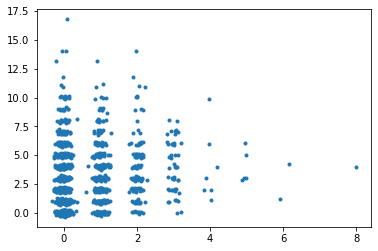

In [11]:
j=0
plt.plot(X[:,j,0]+np.random.normal(scale=0.1,size=n),X[:,j,1]+np.random.normal(scale=0.1,size=n),'.');

### Two states 0.3

In [12]:
theta_hat, weight = traj_EM(X,tau=(0,0.3,1), m=1001, epoch=20, parallel=True, n_threads=14)

100%|███████████████████████████████████████████| 20/20 [08:04<00:00, 24.23s/it]


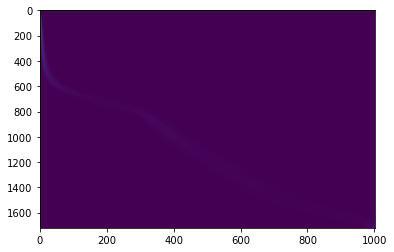

In [18]:
plot_t(weight)

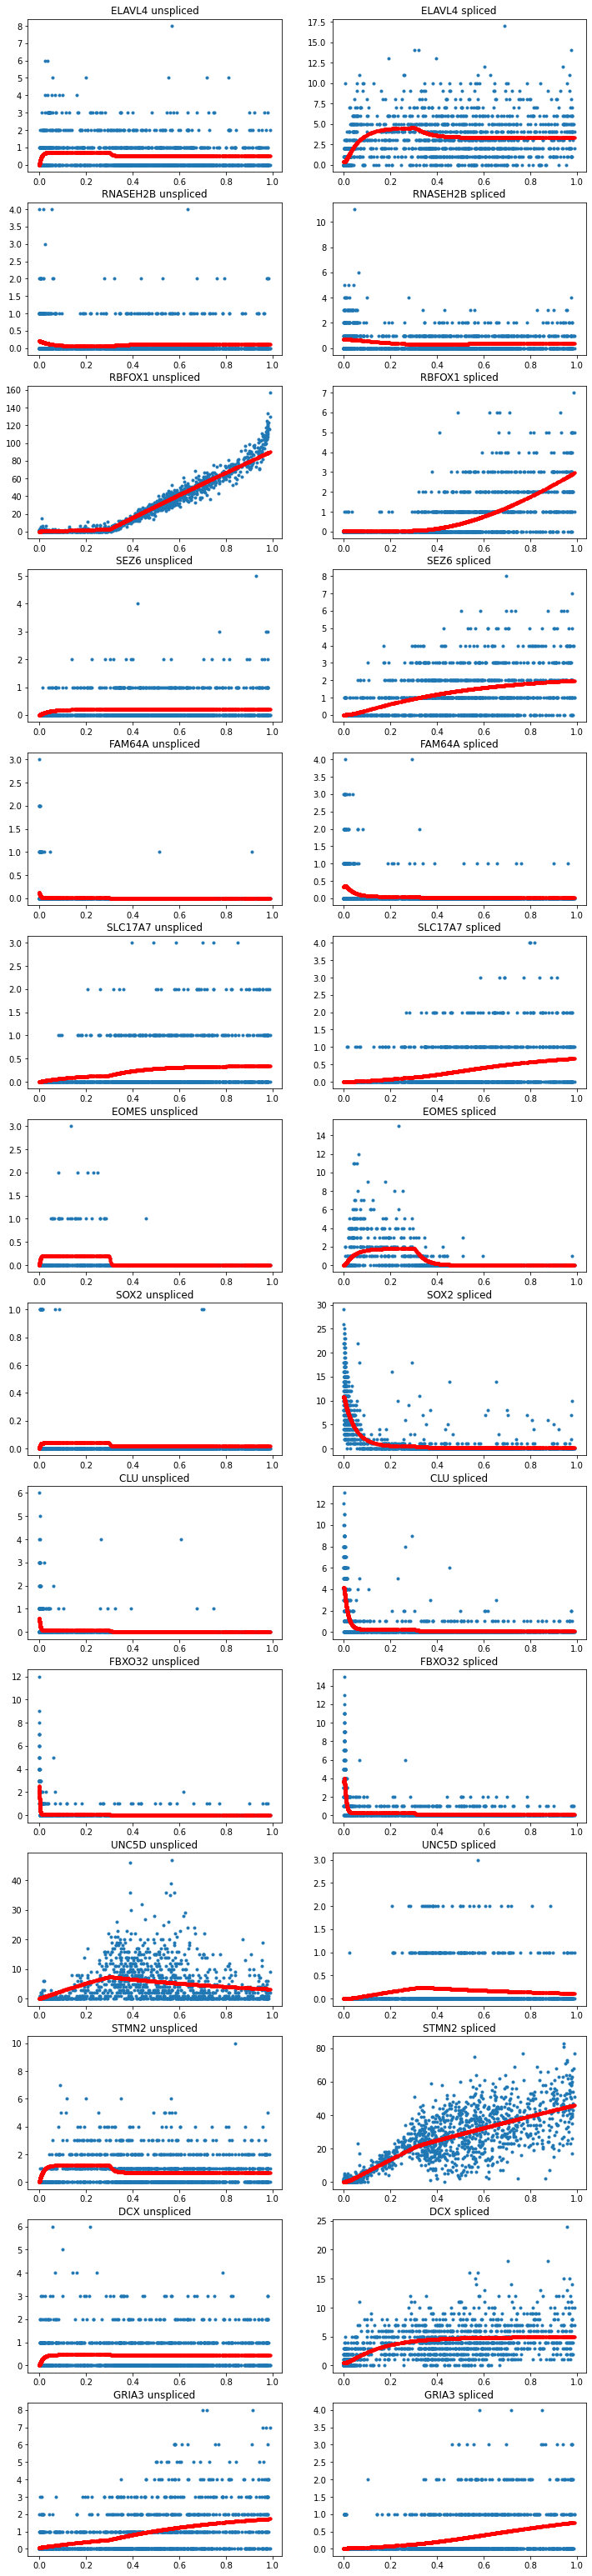

In [19]:
plot_y(theta_hat, weight, (0,0.3,1), gene_list)

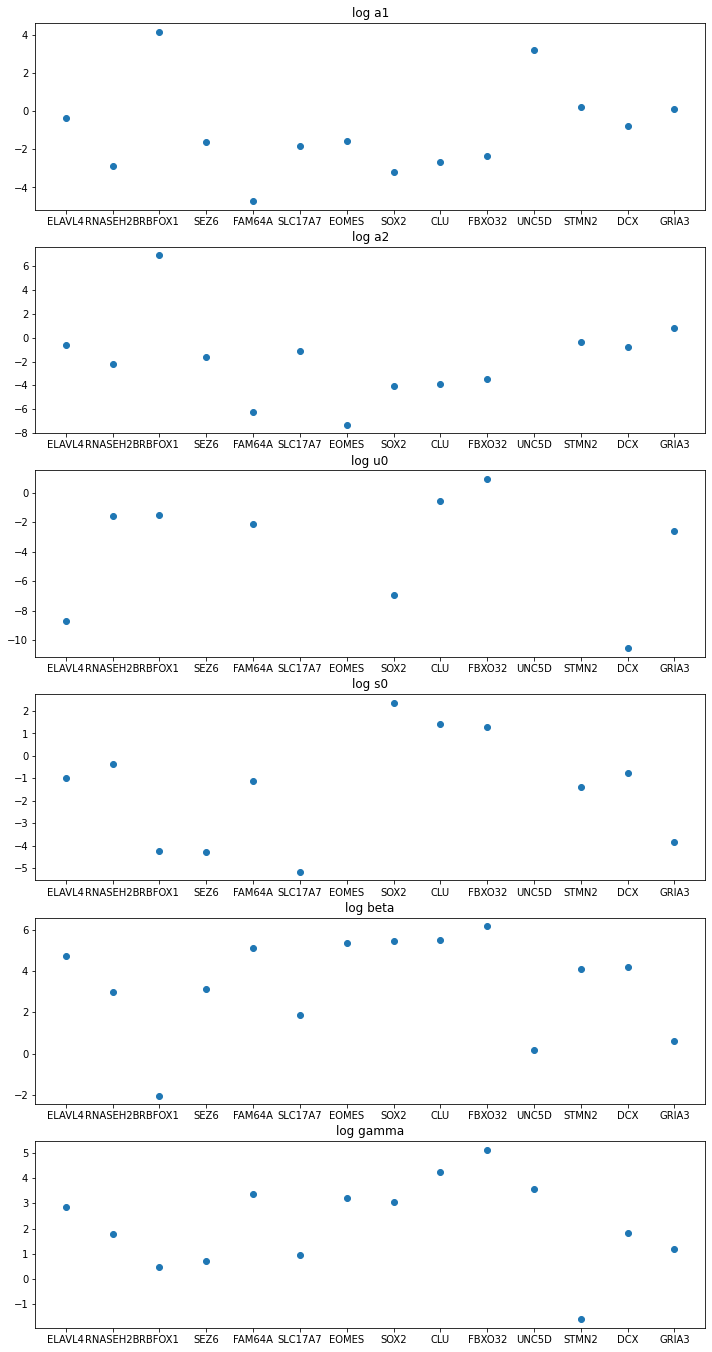

In [20]:
plot_theta_hat(theta_hat,2,gene_list)

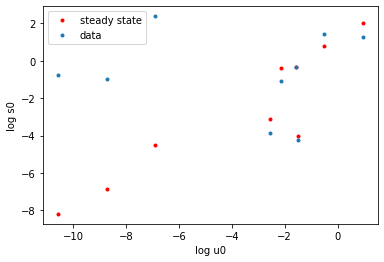

In [21]:
plt.plot(np.log(theta_hat[:,-4]),np.log(theta_hat[:,-4]*theta_hat[:,-2]/theta_hat[:,-1]),'r.',label="steady state");
plt.plot(np.log(theta_hat[:,-4]),np.log(theta_hat[:,-3]),'.',label="data");
plt.xlabel("log u0")
plt.ylabel("log s0")
plt.legend();

**Check cell size** 

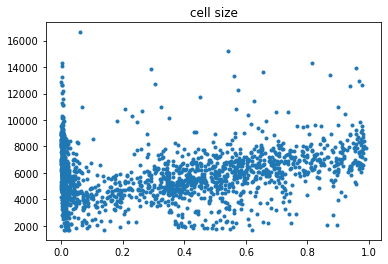

In [22]:
m=np.shape(weight)[1]
h=np.linspace(0,1,m)
t_hat=np.sum(weight*h[None,:],axis=1)
plt.plot(t_hat,np.sum(adata.layers["spliced"],axis=1),'.');
plt.title("cell size");

## Use many non poisson genes

In [23]:
U=adata.layers["unspliced"][:,:].toarray()
S=adata.layers["spliced"][:,:].toarray()

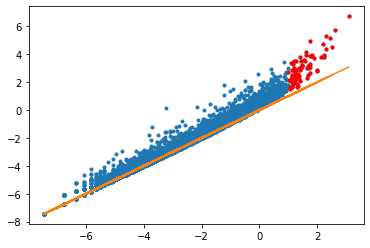

In [62]:
U_mu = np.mean(U,axis=0)
U_var = np.mean((U-U_mu[None,:])**2,axis=0)
idx=U_mu>np.exp(1)
plt.plot(np.log(U_mu),np.log(U_var),'.');
plt.plot(np.log(U_mu[idx]),np.log(U_var[idx]),'r.');
plt.plot(np.log(U_mu),np.log(U_mu));

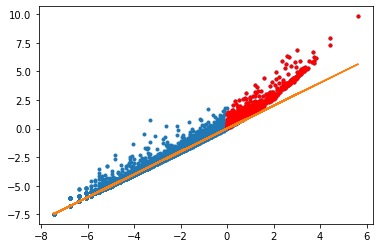

In [87]:
S_mu = np.mean(S,axis=0)
S_var = np.mean((S-S_mu[None,:])**2,axis=0)
idx=(S_mu>np.exp(0)) & ((S_var/S_mu-1)/S_mu>0.1)
plt.plot(np.log(S_mu),np.log(S_var),'.');
plt.plot(np.log(S_mu[idx]),np.log(S_var[idx]),'r.');
plt.plot(np.log(S_mu),np.log(S_mu));

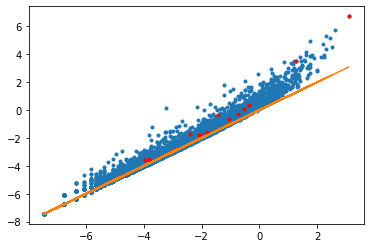

In [81]:
plt.plot(np.log(U_mu),np.log(U_var),'.');
plt.plot(np.log(U_mu[marker_idx]),np.log(U_var[marker_idx]),'r.');
plt.plot(np.log(U_mu),np.log(U_mu));

In [89]:
gene_list=adata.var_names[idx]
u=adata.layers["unspliced"][:,idx].toarray()
s=adata.layers["spliced"][:,idx].toarray()
n,p=np.shape(s)
X=np.zeros((n,p,2))
X[:,:,0]=u
X[:,:,1]=s

In [90]:
plot_idx = gene_list.isin(marker_genes)
gene_list[plot_idx]

Index(['ELAVL4', 'SOX2', 'CLU', 'STMN2', 'DCX'], dtype='object', name='Gene')

In [96]:
theta_hat, weight = traj_EM(X,tau=(0,0.3,1), m=1001, epoch=20, parallel=True, n_threads=40)

100%|████████████████████████████████████████| 20/20 [2:36:00<00:00, 468.03s/it]


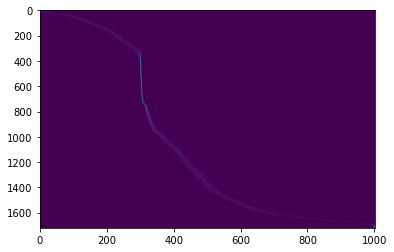

In [99]:
plot_t(weight)

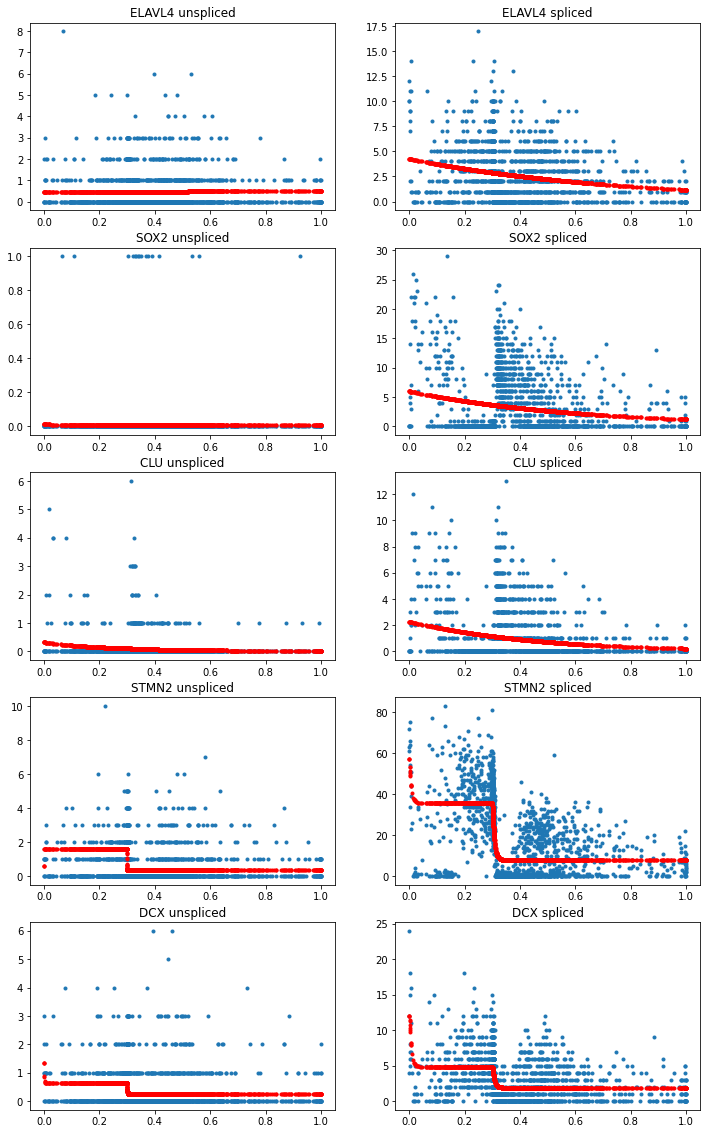

In [100]:
plot_y(X[:,plot_idx,:],theta_hat[plot_idx,:], weight, (0,0.3,1), gene_list[plot_idx])